In [1]:
#interactive widgets in vs code
%matplotlib widget

#dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bagpy
from bagpy import bagreader


In [2]:
# Read rosbag data
bag = bagreader("data/test2.bag")

# extract data from bag, and convert to pandas dataframe
accel_df = pd.read_csv(bag.message_by_topic('/imu/acceleration'))
gyro_df = pd.read_csv(bag.message_by_topic('/imu/angular_velocity'))

[INFO]  Data folder data/test2 already exists. Not creating.


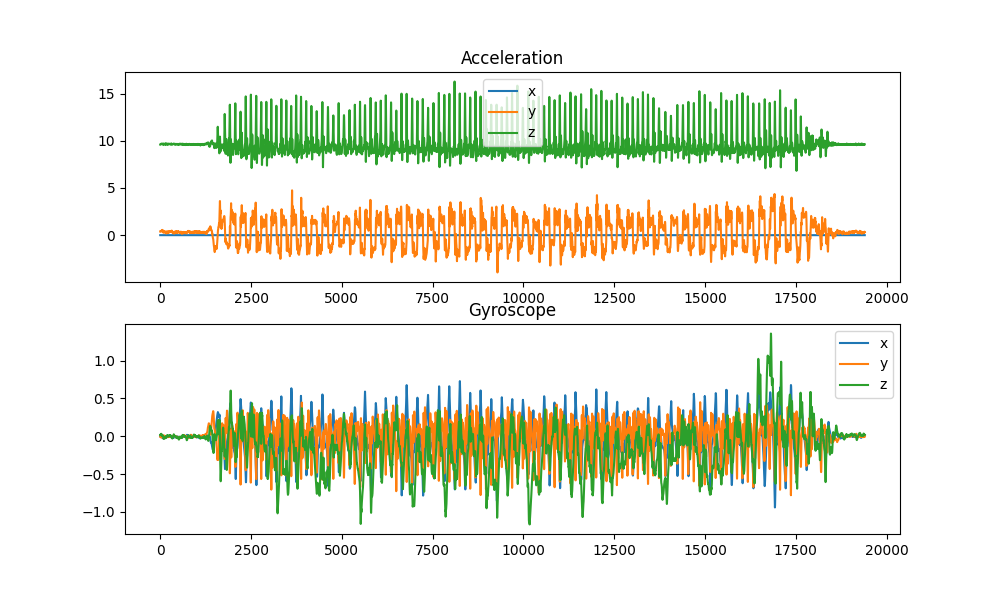

In [22]:
# calculate time difference between measurements
timesteps = (accel_df['header.stamp.secs'].diff(1) + accel_df['header.stamp.nsecs'].diff(1) / 1e9).to_numpy()

# take rolling average of IMU data and store to numpy array, this is to filter noise
averaging_window = 5
vec_accel_raw = accel_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()
vec_gyro_raw = gyro_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()

# longer averaging to get bias over time
accel_bias = -accel_df[['vector.x', 'vector.y', 'vector.z']].rolling(10000).mean().to_numpy()

# replace nan values using closest value
def replace_nan(a):
    ind = np.where(~np.isnan(a))[0]
    first, last = ind[0], ind[-1]
    a[:first] = a[first]
    a[last + 1:] = a[last]
    return a

timesteps = replace_nan(timesteps)
vec_accel_raw = replace_nan(vec_accel_raw)
vec_gyro_raw = replace_nan(vec_gyro_raw)
#accel_bias = replace_nan(accel_bias)

# do calibrations based on scale and bias values
accel_bias =  np.array([ 0.004432,  0.009620, -0.011343])
accel_scale = np.array([ 0.000081, -0.000767,  0.000080])
gyro_bias =   np.array([-0.003728,  0.000588, -0.001389])
# gyro scale ignored as there are no good calibration values.

vec_accel = accel_bias + (1 + accel_scale) * vec_accel_raw
vec_gyro = gyro_bias + vec_gyro_raw

vec_accel[:, 0] = 0


# Plot acceleration and gyroscope data
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(vec_accel)
plt.title('Acceleration')
plt.legend(['x', 'y', 'z'])
plt.subplot(2,1,2)
plt.plot(vec_gyro)
plt.title('Gyroscope')
plt.legend(['x', 'y', 'z'])
plt.show()

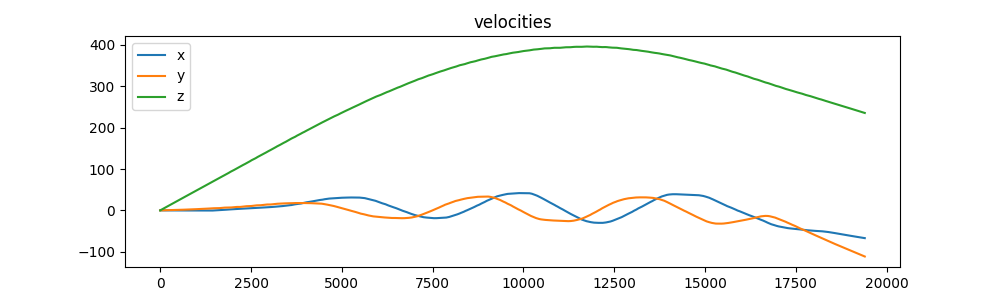

In [23]:
# integrate angular velocity to find rotation (multiply with timestep, then cumulative sum)
vec_rotation = np.cumsum(vec_gyro * timesteps[:, np.newaxis], axis=0)

# rotation calculations
vec_accel_rotated = np.zeros_like(vec_accel)

for nr, rotation_measure in enumerate(vec_rotation):    # loop over vectors
    roll, pitch, yaw = rotation_measure
    rollMatrix = np.matrix([                    # rotation about x
        [1, 0,             0           ],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll),  np.cos(roll)]])
    pitchMatrix = np.matrix([                   # rotation about y
        [ np.cos(pitch), 0, np.sin(pitch)],
        [0,              1,  0           ],
        [-np.sin(pitch), 0, np.cos(pitch)]])
    yawMatrix = np.matrix([                     # rotation about z
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]])

    R = yawMatrix * pitchMatrix * rollMatrix        # combined rotation matrix
    accel_rotated = np.matmul(R, vec_accel[nr])     # matrix multiplication with accel vector

    vec_accel_rotated[nr, :] = accel_rotated        # add to array

# integrate accel and velocity to get position (multiply with timestep, then cumulative sum)
vec_velocity = np.cumsum(vec_accel_rotated * timesteps[:, np.newaxis], axis=0)
vec_position = np.cumsum(vec_velocity * timesteps[:,np.newaxis], axis=0)


# plot the data to get an idea of the values
plt.figure(figsize=(10, 3))
plt.plot(vec_velocity)
plt.title('velocities')
plt.legend(['x', 'y', 'z'])
plt.show()

In [24]:
# calculate magnitude of drift
start_pos = vec_position[:500].mean(axis=0)
end_pos = vec_position[-500:].mean(axis=0)

drift = end_pos - start_pos
drift

array([  170.50736129,  -526.18049044, 26865.40823045])

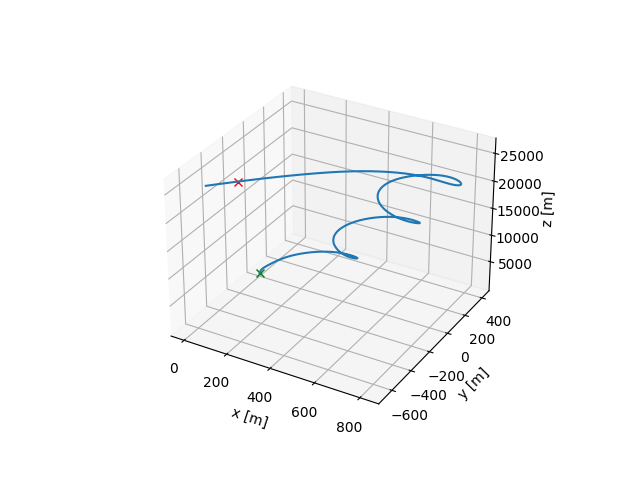

In [25]:
# plot trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = vec_position[:, 0]
ydata = vec_position[:, 1]
zdata = vec_position[:, 2]

ax.plot(*start_pos, 'gx')
ax.plot(*end_pos, 'rx')
ax.plot(xdata, ydata, zdata)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()